This notebook allows you to skeletonize one object in a segmentation using the topological thinning method

In [1]:
# import segmentations
from cerebellum.utils.data_io import *
import json

with open('data_locs.json') as f:
	data_locs = json.load(f)
block_index = 0 # TO CHANGE: which block you are processing
zz = data_locs["block-size"]*block_index+14

# load GT and initial segmentation
gt_file = data_locs["trials"]["dir"] + data_locs["trials"]["gt48nm-cropped-relabeled"]
pred_file = data_locs["trials"]["dir"] + data_locs["trials"]["pf48nm-cropped-relabeled"]
if zz!=14: # adjust block index
    gt_file = gt_file[:-7]+"%04d.h5"%(zz)
    pred_file = pred_file[:-7]+"%04d.h5"%(zz)
gt = read3d_h5(gt_file, 'main')
pred = read3d_h5(pred_file, 'main')
print gt.shape, pred.shape

/home/srujanm/anaconda2/envs/em/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(90, 540, 488) (90, 540, 488)


In [2]:
# generate mask for one object in segmentation
prefix = "pred-trial" # TO CHANGE
test_id = 2252 # TO CHANGE
output_resolution=(80,80,80)
if prefix == "pred-trial":
    obj_mask = np.zeros_like(pred, dtype=np.int64)
    obj_mask[pred==test_id] = 1
elif prefix == "gt-trial":
    obj_mask = np.zeros_like(gt, dtype=np.int64)
    obj_mask[gt==test_id] = 1

In [3]:
# downsample
from cerebellum.ibex.transforms.seg2seg import DownsampleMapping
# generate downsampled file
DownsampleMapping(prefix, obj_mask, output_resolution=output_resolution)

Downsampling to resolution (80, 80, 80) in 0.0780780315399 seconds


In [4]:
# run skeletonization method
from cerebellum.ibex.skeletonization.generate_skeletons import TopologicalThinning, FindEndpointVectors
TopologicalThinning(prefix, obj_mask, skeleton_resolution=output_resolution)
FindEndpointVectors(prefix, skeleton_resolution=output_resolution)

Topological thinning time for (80, 80, 80): 0.0244839191437
Endpoint vector time for (80, 80, 80): 0.00348114967346


In [5]:
from cerebellum.ibex.skeletonization.generate_skeletons import FindEdges
FindEdges(prefix, skeleton_resolution=output_resolution)

Edge finding time for (80, 80, 80): 0.00109386444092


In [6]:
# read upsampled skeleton file
from cerebellum.ibex.utilities.dataIO import ReadSkeletons
skeletons = ReadSkeletons(prefix, read_edges=True, downsample_resolution=output_resolution)

In [7]:
# extract joints
skel_id = 1
n_joints = len(skeletons[skel_id].joints)
joints = np.zeros((n_joints,3))
for i in range(n_joints):
    joints[i,:] = np.array([skeletons[skel_id].joints[i].iz, 
                            skeletons[skel_id].joints[i].iy, 
                            skeletons[skel_id].joints[i].ix])

In [8]:
# extract endpoints and endpoint vectors
n_endpoints = len(skeletons[skel_id].endpoints)
endpoints = np.zeros((n_endpoints,3))
endpoint_vecs = np.zeros((n_endpoints,3))
for i in range(n_endpoints):
    endpoints[i,:] = np.array([skeletons[skel_id].endpoints[i].iz, 
                            skeletons[skel_id].endpoints[i].iy, 
                            skeletons[skel_id].endpoints[i].ix])
    endpoint_vecs[i,:] = skeletons[skel_id].endpoints[i].vector

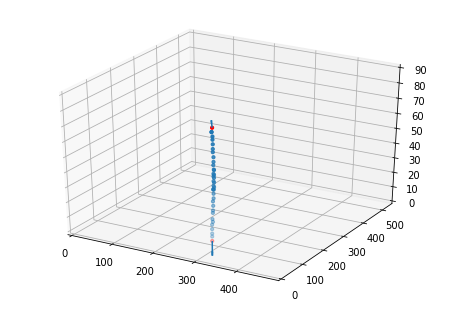

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(joints[:,2],joints[:,1],joints[:,0], s=10)
ax.set_xlim3d(0,skeletons[skel_id].grid_size[2])
ax.set_ylim3d(0,skeletons[skel_id].grid_size[1])
ax.set_zlim3d(0,skeletons[skel_id].grid_size[0])

ax.scatter(endpoints[:,2],endpoints[:,1],endpoints[:,0], s=10, c='r')
ax.quiver(endpoints[:,2],endpoints[:,1],endpoints[:,0],
          endpoint_vecs[:,2],endpoint_vecs[:,1],endpoint_vecs[:,0],length=10,normalize=True)
plt.show()

In [10]:
# extract edges
n_edges = len(skeletons[skel_id].edges)
sources = np.zeros((n_edges,3))
targets = np.zeros((n_edges,3))
for i in range(n_edges):
    sources[i,:] = np.array([skeletons[skel_id].edges[i].source.iz,
                             skeletons[skel_id].edges[i].source.iy,
                             skeletons[skel_id].edges[i].source.ix])
    targets[i,:] = np.array([skeletons[skel_id].edges[i].target.iz,
                             skeletons[skel_id].edges[i].target.iy,
                             skeletons[skel_id].edges[i].target.ix])

In [12]:
# plot edges and nodes
nodes = np.vstack((endpoints, joints))
%matplotlib qt
fig2 = plt.figure()
ax = Axes3D(fig2)
ax.scatter(nodes[:,2],nodes[:,1],nodes[:,0], s=10, c='r')
ax.set_xlim3d(0,skeletons[skel_id].grid_size[2])
ax.set_ylim3d(0,skeletons[skel_id].grid_size[1])
ax.set_zlim3d(0,skeletons[skel_id].grid_size[0])

for i in range(n_edges):
    ln_x = [sources[i,2], targets[i,2]]
    ln_y = [sources[i,1], targets[i,1]]
    ln_z = [sources[i,0], targets[i,0]]
    plt.plot(ln_x, ln_y, ln_z, 'b-')
plt.show()